# TensorFlow 实现 Softmax Regression 识别手写数字

In [1]:
import tensorflow as tf

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from tensorflow.examples.tutorials.mnist import input_data

## 1.1 数据介绍

In [17]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


MNIST 数据集来自美国国家标准与技术研究所, National Institute of Standards and Technology (NIST). 训练集 (training set) 由来自 250 个不同人手写的数字构成, 其中 50% 是高中学生, 50% 来自人口普查局 (the Census Bureau) 的工作人员. 测试集(test set) 也是同样比例的手写数字数据。 该数据集一共有60000个训练和20000个试验集组成，特点是样本数量大，数据质量高，特征相对简单，比较适合学习算法和模式识别的初学者进行入门演练。

可以看到我们导入的数据集共有55000个训练样本和10000个测试样本。自变量为一个28 * 28的像素矩阵，元素值为0到1之间，标签为0-9的整数。


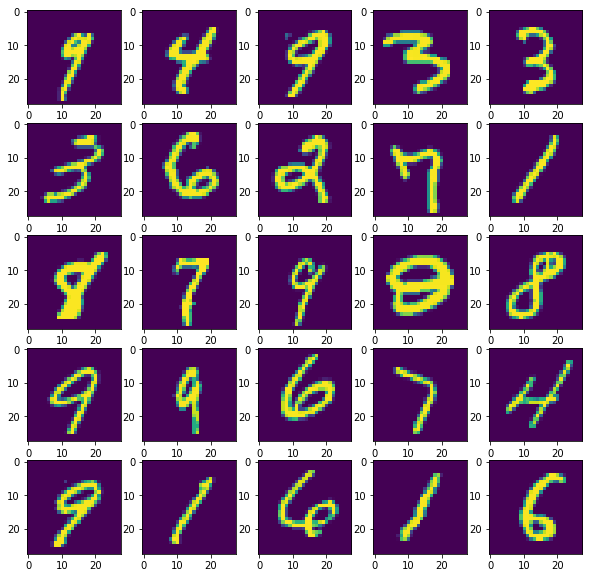

In [16]:
import matplotlib.pyplot as plt
nfigs = 5
fig = plt.figure(figsize=(10,10))
for i in range(nfigs ** 2):
    ax = fig.add_subplot(nfigs, nfigs, i+1)
    ax.imshow(mnist.train.images[i].reshape(28, 28))

In [6]:
print(mnist.train.images.shape, mnist.train.labels.shape,mnist.test.images.shape, mnist.test.labels.shape)

(55000, 784) (55000, 10) (10000, 784) (10000, 10)


## 1.2 模型构建流程

### 1.2.1 模型介绍

>$ feature_i = \sum_jW_{i,j}x_j + b_i $

>$ softmax(x)  = \frac{exp(x)}{\sum_iexp(x)}$

### 1.2.2 代码实现

分为两个步骤
* 构造步骤
* 运行步骤

In [7]:
'''以下为构造步骤'''
sess = tf.InteractiveSession()  # 初始化一个session，即一个流式图
with tf.variable_scope('input'):
    x = tf.placeholder(tf.float32,[None, 784], name='x')  #创建输入特征的tensor，Param: 数据类型，数据维度
    y_ = tf.placeholder(tf.float32,[None, 10], name='y')  # 创建输入标签的 tensor

with tf.variable_scope('layer'): 
    W = tf.Variable(tf.zeros([784, 10]), name='W')  #初始化模型参数，分别表示权重矩阵和偏倚系数。
    b = tf.Variable(tf.zeros([10]), name='b')
    y_before = tf.matmul(x, W) + b

In [8]:
with tf.variable_scope('output'): 
    y = tf.nn.softmax(y_before, name='y_output')
    tf.summary.histogram('y_output', y)

以上代码初始化了Session，输入数据的类型维度，以及模型参数的类型，维度。

注意：
* Placeholder: 占位符，可以理解为sess声明形参。在run session 的步骤中，必须要先赋值。
* variable: 声明模型中需要训练的参数，需要事先声明参数类型，尺度，以及在训练前需要初始化

最后一行代码定义了模型的映射函数。tf.nn包含了大量神经网络的组件，包括很多激活层函数。tf.matmul顾名思义，为矩阵乘法函数。


In [9]:
with tf.variable_scope('loss'):
    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]), name='cross_entropy')
    tf.summary.scalar('cross_entropy', cross_entropy)

以上代码定义里模型的代价函数，用Cross entropy。其中y_ 为训练样本的标签，同样需要在训练前提前赋值。

In [10]:
with tf.variable_scope('train'):
    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

In [11]:
with tf.variable_scope('evaluate'):
    correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1), name='correct_prediction')
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32), name='accuracy')
    tf.summary.scalar('accuracy', accuracy)

In [12]:
merged = tf.summary.merge_all()
writer = tf.summary.FileWriter(r"C:\Users\Vincent Xu\PycharmProjects\tf_tutorial\logs\\", sess.graph)

以上代码定义了模型的训练算法，使用最普通的一般梯度下降法。tensorFlow 还提供了其他丰富的优化算法。训练算法声明需要设定learning rate的参数

In [13]:
'''以下为执行步骤'''
tf.global_variables_initializer().run()

在正式执行训练参数的操作前，首先需要对全局的参数做初始化。要注意，虽然在之前我们已经声明了模型的参数，但是必须要执行该步，才使得参数真正的被初始化了。

In [14]:
for i in range(1000):
    batch_xs, batch_ys = mnist.train.next_batch(100)
    train_step.run({x: batch_xs, y_:batch_ys})
    rs = sess.run(merged,feed_dict={x: batch_xs, y_:batch_ys})
    writer.add_summary(rs, i)

以上代码迭代的训练了我们的分类器。next_batch 操作，每次都从训练样本集中选取一定数量的样本进行训练，该方法也被称为随机梯度下降法（SGD）。参数100 表示epoch，即表示总每100个batch将所有训练集遍历。

In [15]:
print('准确率为%1.6f'%(accuracy.eval({x: mnist.test.images, y_:mnist.test.labels})))

准确率为0.918000


以上代码为检验模型准确率的操作。使用Softmax Regression 大致可以使得在测试集上的准确率大致达到92%（此样本各类比例大致相同）